# Weather Predictions

Some notes before proceeding:
- histday == previous forecasts at the day level
- histhour == previous forecasts at the hour level

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import math
from crate import client

In [2]:
# Configuration
pd.set_option('display.max_rows', 500)

In [3]:
node_url = 'http://localhost:4301/'
username = 'crate'


In [4]:
def query_to_df(table):
    query = "SELECT * FROM " + table
    connection = client.connect(node_url, username=username)
    cursor = connection.cursor()
    cursor.execute(query)
    data = cursor.fetchall()
    columns = [column[0] for column in cursor.description]
    connection.close()
    df = pd.DataFrame(data, columns=columns)
    return df

In [5]:
def floor(x):
    x = math.ceil(x/20) * 20
    return x

In [6]:
def get_and_clean_cur_weather():
    table = "cur_weather" # Ensure double quotes are used 
    df = query_to_df(table).sort_values('localtime_epoch').reset_index(drop=True)
    df['localtime'] = pd.to_datetime(df['localtime_epoch'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Phnom_Penh')
    df['last_updated'] = pd.to_datetime(df['last_updated_epoch'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Phnom_Penh')
    df = df.drop(['localtime_epoch','last_updated_epoch'], axis=1)
    df['year'] = df['localtime'].dt.year
    df['month'] = df['localtime'].dt.month
    df['day'] = df['localtime'].dt.day
    df['hour'] = df['localtime'].dt.hour
    df['minute'] = df['localtime'].dt.minute
#     df['minute'] = df['minute'].map(floor)
    return df

In [7]:
def get_and_clean_for_weather():
    table = "for_weather" # Ensure double quotes are used 
    df = query_to_df(table).sort_values('localtime_epoch')
    df.dropna(inplace=True)
    df = df.reset_index(drop=True)
    df['localtime'] = pd.to_datetime(df['localtime_epoch'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Phnom_Penh')
    df['0D_date'] = pd.to_datetime(df['0D_date_epoch'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Phnom_Penh')
    df['1D_date'] = pd.to_datetime(df['1D_date_epoch'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Phnom_Penh')
    df['2D_date'] = pd.to_datetime(df['2D_date_epoch'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Phnom_Penh')
    df = df.drop(['0D_date_epoch','1D_date_epoch','2D_date_epoch'], axis=1)
    
    keys = {}
    for day in df['0D_date'].unique():
        keys[day] = {}
        for D in ['0D_', '1D_', '2D_']:
            for column in [x for x in df.columns if D in x]:
                if df[column].dtype in ['float64','int64']:
                    keys[day]['cur' + column + '_mean'] = df[df['0D_date'] == day][column].describe()[1]
                    keys[day]['cur' + column + '_std'] = df[df['0D_date'] == day][column].describe()[2]
                    keys[day]['cur' + column + '_states'] = len(df[df['0D_date'] == day][column].unique())
                elif df[column].dtype in ['O','string']:
                    keys[day]['cur' + column + '_consensus'] = (df[df['0D_date'] == day][column].value_counts()[0] / df[df['0D_date'] == day][column].shape[0])
                    keys[day]['cur' + column + '_states'] = len(df[df['0D_date'] == day][column].unique())
    
    # get the days lined up in a dict

#     today_cols = [x for x in keys[df['0D_date'].unique()[0]].keys() if '0D' in x]
    yesterday_cols = [x for x in keys[df['0D_date'].unique()[0]].keys() if '1D' in x]
    daybefore_cols = [x for x in keys[df['0D_date'].unique()[0]].keys() if '2D' in x]

    aligned_for1 = pd.DataFrame(columns=['0D_date'])
    aligned_for2 = pd.DataFrame(columns=yesterday_cols)
    aligned_for3 = pd.DataFrame(columns=daybefore_cols)
    aligned_for = pd.concat([aligned_for1, aligned_for2, aligned_for3])

    forecast_avg = pd.DataFrame.from_dict(keys, orient='index')

    for day in df['0D_date'].unique()[2:]:
        target_day = day
#         today = target_day
        yesterday = target_day - pd.DateOffset(1)
        daybefore = target_day - pd.DateOffset(2)

        temp = pd.Series({'0D_date': day})
        temp = temp.append(forecast_avg.loc[yesterday][yesterday_cols])
        temp = temp.append(forecast_avg.loc[daybefore][daybefore_cols])

        aligned_for = aligned_for.append(temp, ignore_index=True)
        
    aligned_for['0D_date'] = pd.to_datetime(aligned_for['0D_date'])
        
    df = pd.merge(df, aligned_for, on='0D_date')

    return df

In [8]:
def get_and_clean_hist_weather():
    table = "histday_weather" # Ensure double quotes are used 
    df = query_to_df(table).sort_values('date_epoch').reset_index(drop=True)
    df['date'] = pd.to_datetime(df['date_epoch'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Phnom_Penh')
    df = df.drop('date_epoch', axis=1)
    
    table = "histhour_weather" # Ensure double quotes are used 
    df2 = query_to_df(table).sort_values('time_epoch').reset_index(drop=True)
    df2['time'] = pd.to_datetime(df2['time_epoch'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Phnom_Penh')
    df2 = df2.drop('time_epoch', axis=1)
    return df, df2

In [9]:
def get_all_clean_weather():
    left = get_and_clean_cur_weather()
    print('%s rows in cur' % left.shape[0])
    right = get_and_clean_for_weather()
    print('%s rows in for' % right.shape[0])
    df = pd.merge_asof(left, right, direction='nearest', tolerance=pd.Timedelta('120s')) # This will get the nearest forecast to the current weather, whether taking place before or after, and within 2 minutes
#     df = pd.merge_asof(left, right, direction='backward') # This will get the latest forecast up to the current time, but not after, regardless of how long away

    # Running 'backward' creates a gaps of 20 minutes or longer between cur and for associations, as the forecast seems to take place after the current weather is posted to the API. therefore prefer to use nearest for matching, as we can run the model a few moments after the forecast comes in to make the prediction.
    
#     print('%s rows before drop' % df.shape[0])
#     df.dropna(inplace=True)
#     print('%s rows after drop' % df.shape[0])
    return df

In [10]:
df = get_all_clean_weather().dropna(subset=['localtime_epoch']).reset_index()
df.shape

839 rows in cur
752 rows in for


(629, 141)

In [11]:
df.loc[df['precip_mm'] > 0, 'is_raining'] = 1
df['is_raining'] = df['is_raining'].fillna(0)
df['localtime_revert'] = df['localtime'].astype(int) / 1000000000
df['timediff'] = df['localtime_revert'] - df['localtime_epoch']
# df['timediff']

## Data Exploration

In [12]:
corr = pd.DataFrame(df.corr()['precip_mm']).reset_index()
corr[(corr['precip_mm'] < -.4) | (corr['precip_mm'] > .4)]

,index,precip_mm
6,precip_mm,1.000000
8,cloud,0.476576
10,vis_km,-0.649864
12,gust_kph,0.496825
16,hour,0.400927
131,is_raining,0.770219


In [13]:
corr = pd.DataFrame(df.corr()['is_raining']).reset_index()
sig = corr[(corr['is_raining'] < -.4) | (corr['is_raining'] > .4)]
sig

,index,is_raining
3,wind_kph,0.558327
6,precip_mm,0.770219
8,cloud,0.582292
10,vis_km,-0.535088
12,gust_kph,0.632914
131,is_raining,1.000000


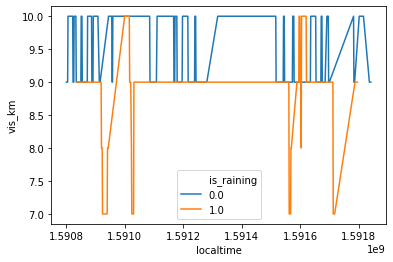

In [14]:
sns.lineplot(x=df['localtime'].astype(np.int64) // 10**9, y=df['vis_km'], hue=df['is_raining'])

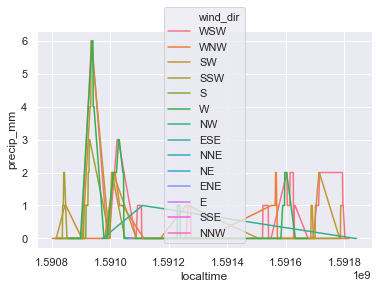

In [15]:
sns.set(style="darkgrid")
sns.lineplot(x=df['localtime'].astype(np.int64) // 10**9, y=df['precip_mm'], hue=df['wind_dir'])

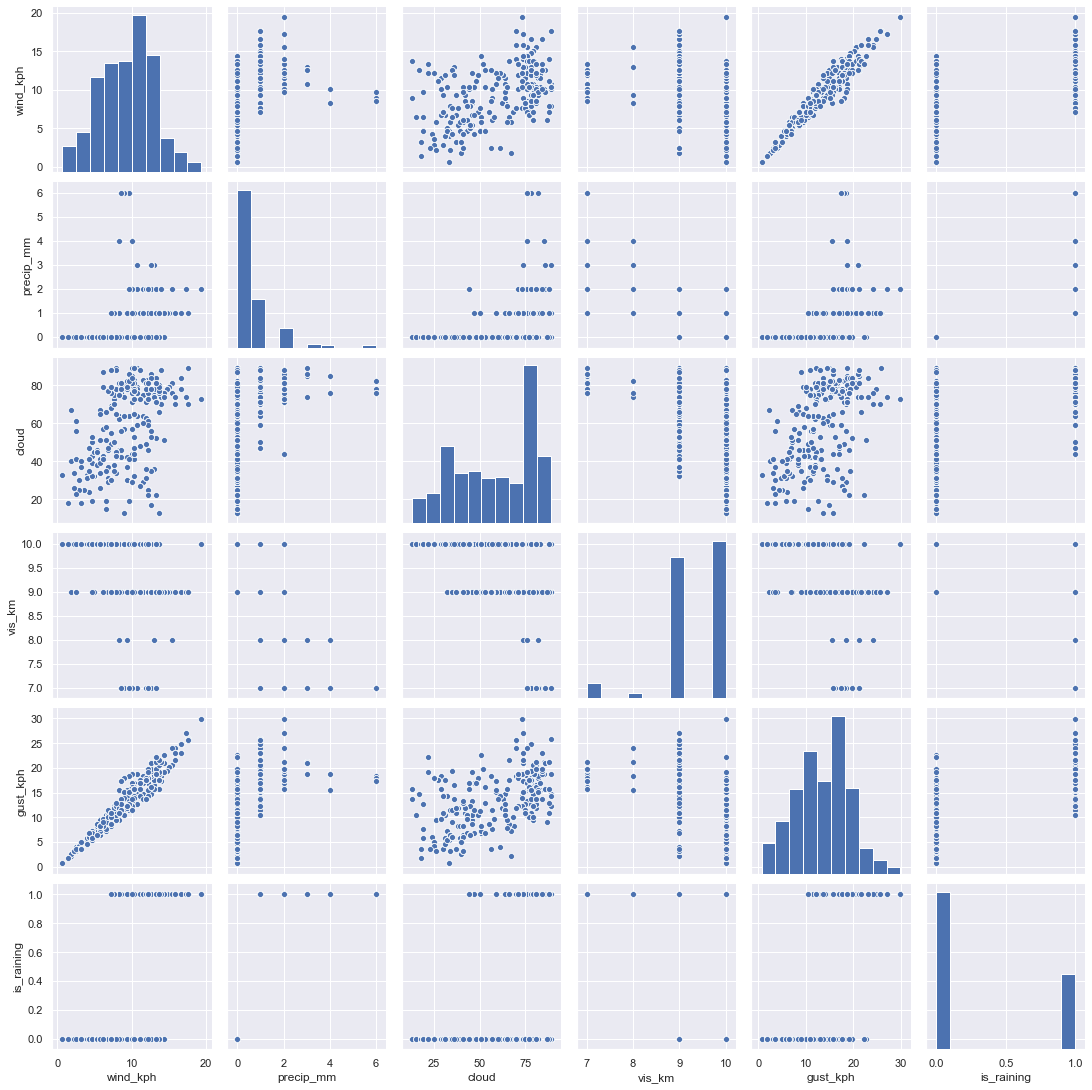

In [16]:
sig_columns = sig['index'].values
sns.pairplot(df[sig_columns])

## Creation of prediction value

The values generated here take precipitation and raining flags associated with the current time and apply a time penalty to copy them to timestamps already passed. By these means, the current timestamp will have the future reality according to the time intervals of 1, 2, 3, 6, and 12 hours. These data will serve as the true y values for model evaluation.

In [17]:
pred_df = df[['localtime','localtime_epoch','precip_mm','is_raining']]
pred_df['localtime_epoch'] = pd.to_datetime(df['localtime_epoch'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Phnom_Penh')
pred_df['is_raining'] = pred_df['is_raining'].astype(int)

hours = [1,2,3,6,12]
pred_labels = []
for hour in hours:
    prefix = str(hour) + 'h'
    new_timecolumn = prefix + 'localtime'
    new_precipmm = prefix + 'precip_mm'
    new_willrainlabel = prefix + 'will_rain'
    pred_df[new_timecolumn] = df['localtime'] - pd.Timedelta(str(hour) + 'h')
    temp = pred_df[[new_timecolumn, 'precip_mm','is_raining']]
    temp = temp.rename({new_timecolumn: 'localtime', 'precip_mm': new_precipmm, 'is_raining': new_willrainlabel}, axis=1)
    df = pd.merge_asof(df, temp, direction='nearest', tolerance=pd.Timedelta('720s'))
    pred_labels.append(new_willrainlabel)
    pred_labels.append(new_precipmm)

C:\Users\icarter\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\icarter\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\icarter\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [18]:
column = '3hwill_rain'
pred_corr = pd.DataFrame(df.corr()[column]).reset_index()
pred_corr[(pred_corr[column] < -.4) | (pred_corr[column] > .4)]

,index,3hwill_rain
1,temp_c,0.499385
3,wind_kph,0.418698
7,humidity,-0.459977
9,feelslike_c,0.501877
135,1hwill_rain,0.524250
136,2hprecip_mm,0.577237
137,2hwill_rain,0.724166
138,3hprecip_mm,0.775360
139,3hwill_rain,1.000000


In [19]:
df.dtypes

index                                                          int64
localtime                            datetime64[ns, Asia/Phnom_Penh]
last_updated                         datetime64[ns, Asia/Phnom_Penh]
temp_c                                                       float64
is_day                                                         int64
condition                                                     object
wind_kph                                                     float64
wind_degree                                                    int64
wind_dir                                                      object
pressure_mb                                                    int64
precip_mm                                                      int64
humidity                                                       int64
cloud                                                          int64
feelslike_c                                                  float64
vis_km                            

In [20]:
pred_labels

['1hwill_rain',
 '1hprecip_mm',
 '2hwill_rain',
 '2hprecip_mm',
 '3hwill_rain',
 '3hprecip_mm',
 '6hwill_rain',
 '6hprecip_mm',
 '12hwill_rain',
 '12hprecip_mm']

In [21]:
for i in range(0, len(pred_labels), 2):
    print(pred_labels[i])

1hwill_rain
2hwill_rain
3hwill_rain
6hwill_rain
12hwill_rain


In [22]:
drop_columns = ['localtime','last_updated','index','wind_degree','localtime_epoch','0D_date','1D_date','2D_date','timediff','localtime_revert']
clean_df = df.drop(drop_columns, axis=1)

In [23]:
cat_cols = []
for col in clean_df.columns:
    if clean_df[col].dtype == 'object':
        cat_cols.append(col)

In [24]:
for col in cat_cols:
    clean_df[col] = clean_df[col].astype('category')

## Model Construction

In [25]:
# from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, BayesianRidge, LassoLarsIC, LogisticRegression
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.kernel_ridge import KernelRidge
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
# from sklearn.metrics import mean_squared_error

### Train/Test splitting

In [26]:
onehotcols = ['condition','wind_dir','0D_condition','1D_condition','2D_condition']
onehotclean_df = pd.get_dummies(clean_df, columns=onehotcols)
onehotclean_df.dropna(inplace=True)

In [27]:
OX = onehotclean_df.drop(pred_labels, axis=1).values
Oy = onehotclean_df['6hwill_rain'].values

In [28]:
OX_train, OX_test, Oy_train, Oy_test = train_test_split(OX, Oy, test_size=.2, random_state=1337)

In [117]:
# Deprecated until a way is found to handle categorical data

# X = clean_df.drop(pred_labels, axis=1).values
# y = clean_df['1hwill_rain'].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1337)

### Classification Models

#### Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier

In [30]:
for i in range(0, len(pred_labels), 2):
    OX = onehotclean_df.drop(pred_labels, axis=1).values
    Oy = onehotclean_df[pred_labels[i]].values
    OX_train, OX_test, Oy_train, Oy_test = train_test_split(OX, Oy, test_size=.2, random_state=1337)
    DTclf = DecisionTreeClassifier(random_state=2020)
    DTclf.fit(OX_train, Oy_train)
    DTclf.predict(OX_test)
    DTclf.score(OX_test, Oy_test)
    score = DTclf.score(OX_test, Oy_test)
    print('Prediction returned as %s' % score)

Prediction returned as 0.9801980198019802
Prediction returned as 0.9801980198019802
Prediction returned as 0.9306930693069307
Prediction returned as 0.9306930693069307
Prediction returned as 0.9207920792079208


#### Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression

# Need to address ConvergenceWarning

In [32]:
for i in range(0, len(pred_labels), 2):
    OX = onehotclean_df.drop(pred_labels, axis=1).values
    Oy = onehotclean_df[pred_labels[i]].values
    OX_train, OX_test, Oy_train, Oy_test = train_test_split(OX, Oy, test_size=.2, random_state=1337)
    LRclf = LogisticRegression(random_state=2020).fit(OX_train, Oy_train)
    LRclf.predict(OX_test)
    LRclf.predict_proba(OX_test)
    score = LRclf.score(OX_test, Oy_test)
    print(': Prediction returned as %s' % score)

: Prediction returned as 0.9207920792079208
: Prediction returned as 0.8712871287128713
: Prediction returned as 0.8118811881188119
: Prediction returned as 0.8316831683168316
: Prediction returned as 0.8217821782178217


C:\Users\icarter\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\icarter\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

In [33]:
clf = LogisticRegression(random_state=2020).fit(OX_train, Oy_train)
clf.predict(OX_test)
clf.predict_proba(OX_test)
clf.score(OX_test, Oy_test)

C:\Users\icarter\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8217821782178217

### Regression Models